In [1]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, modified_precision
from nltk.translate.chrf_score import sentence_chrf, corpus_chrf
from nltk.metrics import scores
import scipy.io.wavfile
from IPython.display import Audio
from IPython.display import display
from nltk.stem import *
# from nltk.stem.snowball import SnowballStemmer
from stemming.porter2 import stem
import stemming
from nltk.metrics.scores import recall

from nltk.corpus import stopwords

%matplotlib inline

In [2]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [3]:
smooth_fun = nltk.translate.bleu_score.SmoothingFunction()

In [4]:
from nmt_run import *

In [5]:
def play_utt(utt, m_dict):
    sr, y = scipy.io.wavfile.read(os.path.join(wavs_path, utt.rsplit("-",1)[0]+'.wav'))
    start_t = min(seg['start'] for seg in m_dict[utt]['seg'])
    end_t = max(seg['end'] for seg in m_dict[utt]['seg'])
    print(start_t, end_t)
    start_t_samples, end_t_samples = int(start_t*sr), int(end_t*sr)
    display(Audio(y[start_t_samples:end_t_samples], rate=sr))

In [6]:
def display_words(m_dict, v_dict, preds, utts, dec_key, key, play_audio=False, displayN=-1):
    if displayN == -1:
        displayN = len(utts)
    es_ref = []
    en_ref = []
    google_ref = []
    google_pred = []
    for u in utts:
        es_ref.append(" ".join([w.decode() for w in m_dict[u]['es_w']]))
        if type(m_dict[u][dec_key]) == list:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
        else:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w'][0]]))
        google_pred.append(" ".join(google_hyp_r0[u]))
        google_ref.append(" ".join(google_dev_ref_0[u]))

    en_pred = []
    join_str = ' ' if dec_key.endswith('_w') else ''

    for p in preds:
        if type(p) == list:
            t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
            t_str = t_str[:t_str.find('_EOS')]
            en_pred.append(t_str)
        else:
            en_pred.append("")
        

    for u, es, en, p, g, gr in sorted(list(zip(utts, es_ref, en_ref, en_pred, google_pred, google_ref)))[:displayN]:
        # for reference, 1st word is GO_ID, no need to display
        print("Utterance: {0:s}".format(u))
        display_pp = PrettyTable(["cat","sent"], hrules=True)
        display_pp.align = "l"
        display_pp.header = False
        display_pp.add_row(["es ref", textwrap.fill(es,50)])
        display_pp.add_row(["en ref", textwrap.fill(en,50)])
        display_pp.add_row(["model pred", textwrap.fill(p,50)])
        display_pp.add_row(["model bleu", "{0:.2f}".format(sentence_bleu([en], p, smoothing_function=smooth_fun.method2))])
        display_pp.add_row(["google pred", textwrap.fill(g,50)])
        display_pp.add_row(["google bleu", "{0:.2f}".format(sentence_bleu([gr], g, smoothing_function=smooth_fun.method2))])
    

        print(display_pp)
        if play_audio:
            play_utt(u, m_dict)
    

In [7]:
def make_pred(utt, X, y=None, display_limit=10):
    # get shape
    batch_size = X.shape[0]
    # encode input
    model.forward_enc(X)
    # ---------------------------------------------------------------------
    # initialize decoder LSTM to final encoder state
    # ---------------------------------------------------------------------
    model.set_decoder_state()
    # ---------------------------------------------------------------------
    # swap axes of the decoder batch
    if y is not None:
        y = F.swapaxes(y, 0, 1)
    # -----------------------------------------------------------------
    # predict
    # -----------------------------------------------------------------
    # make return statements consistent
    return(decode_display(utt, batch_size=batch_size,
                          pred_limit=model.m_cfg['max_en_pred'],
#                           pred_limit=20,
                          y=y, display_limit=display_limit))

In [8]:
def decode_display(utt, batch_size, pred_limit, y=None, display_limit=10):
    xp = cuda.cupy if model.gpuid >= 0 else np
    # max number of predictions to make
    # if labels are provided, this variable is not used
    stop_limit = pred_limit
    # to track number of predictions made
    npred = 0
    # to store loss
    loss = 0
    # if labels are provided, use them for computing loss
    compute_loss = True if y is not None else False
    # ---------------------------------------------------------------------
    if compute_loss:
        stop_limit = len(y)-1
        # get starting word to initialize decoder
        curr_word = y[0]
    else:
        # intialize starting word to GO_ID symbol
        curr_word = Variable(xp.full((batch_size,), GO_ID, dtype=xp.int32))
    # ---------------------------------------------------------------------
    # flag to track if all sentences in batch have predicted EOS
    # ---------------------------------------------------------------------
    with cupy.cuda.Device(model.gpuid):
        check_if_all_eos = xp.full((batch_size,), False, dtype=xp.bool_)
    # ---------------------------------------------------------------------
    a_units = m_cfg['attn_units']
    ht = Variable(xp.zeros((batch_size, a_units), dtype=xp.float32))
    # ---------------------------------------------------------------------
    prob_out = {}
    prob_print_str = []
    while npred < (stop_limit):
        # -----------------------------------------------------------------
        # decode and predict
        #print("decoding with word: {0:s}".format(vocab_dict['en_w']['i2w'][curr_word.data[0].tolist()].decode()))
        pred_out, ht = model.decode(curr_word, ht)
        pred_word = F.argmax(pred_out, axis=1)
        # -----------------------------------------------------------------
        # printing conditional probabilities
        # -----------------------------------------------------------------
        pred_probs = xp.asnumpy(F.softmax(pred_out).data[0])
        top_n_probs = np.argsort(pred_probs)[-display_limit:]
        #print("-"*60)
        #print("predicting word : {0:d}".format(npred))
        prob_print_str.append("-" * 60)
        prob_print_str.append("predicting word : {0:d}".format(npred))
        
        # -----------------------------------------------------------------
#         if npred == 0:
#             sample_word = np.random.choice(range(len(pred_probs)), p=pred_probs)
#             sample_word = np.argsort(pred_probs)[-2]
#             print(np.argsort(pred_probs)[-2], np.argsort(pred_probs)[-1])
#             pred_word = Variable(xp.asarray([sample_word], dtype=xp.int32))
        # -----------------------------------------------------------------
        
        prob_out[npred] = {}
        for pi in top_n_probs[::-1]:
            prob_out[npred][v_dict['i2w'][pi].decode()] = "{0:.3f}".format(pred_probs[pi])
            #print("{0:10s} = {1:5.3f}".format(v_dict['i2w'][pi].decode(), pred_probs[pi]))
            prob_print_str.append("{0:10s} = {1:5.3f}".format(v_dict['i2w'][pi].decode(), pred_probs[pi]))
            
        # -----------------------------------------------------------------
        # save prediction at this time step
        # -----------------------------------------------------------------
        if npred == 0:
            pred_sents = pred_word.data
        else:
            pred_sents = xp.vstack((pred_sents, pred_word.data))
        # -----------------------------------------------------------------
        if compute_loss:
            # compute loss
            loss += F.softmax_cross_entropy(pred_out, y[npred+1],
                                               class_weight=model.mask_pad_id)
        # -----------------------------------------------------------------
        curr_word = pred_word
        # -----------------------------------------------------------------
        # check if EOS is predicted for all sentences
        # -----------------------------------------------------------------
        check_if_all_eos[pred_word.data == EOS_ID] = True
        if xp.all(check_if_all_eos):
            break
        # -----------------------------------------------------------------
        # increment number of predictions made
        npred += 1
        # -----------------------------------------------------------------
    
    out_fname = os.path.join(m_cfg['model_dir'], "probs", "{0:s}_probs.json".format(utt))
    with open(out_fname, "w") as out_f:
        json.dump(prob_out, out_f, indent=4)
    print("saved probs in : {0:s}".format(out_fname))
    return pred_sents.T, loss, "\n".join(prob_print_str)

In [9]:
def check_loss(eg_utt, curr_set='fisher_dev', teacher_ratio=1.0):
    # get shape
    if "train" in curr_set:
        local_input_path = os.path.join(m_cfg['data_path'], m_cfg['train_set'])
        play_audio = False
    else:
        local_input_path = os.path.join(m_cfg['data_path'], m_cfg['dev_set'])
        play_audio = True
        
    eg_utt_bucket = -1
    for i, bucket in enumerate(bucket_dict[curr_set]["buckets"]):
        if eg_utt in bucket:
            eg_utt_bucket = i
            #print("found")
        # end if
    # end for
    #print("found in bucket : {0:d}".format(eg_utt_bucket))
    width_b = bucket_dict[dev_key]["width_b"]
    utt_list = [eg_utt]
    
    batch_data = get_batch(map_dict[curr_set], 
                           enc_key,
                           dec_key,
                           utt_list,
                           vocab_dict,
                           (eg_utt_bucket+1) * width_b,
                           200,
                           input_path=local_input_path)
    
    X, y = batch_data['X'], batch_data['y']
    
    batch_size = X.shape[0]
    # encode input
    model.forward_enc(X)
    # ---------------------------------------------------------------------
    # initialize decoder LSTM to final encoder state
    # ---------------------------------------------------------------------
    model.set_decoder_state()
    # ---------------------------------------------------------------------
    y = F.swapaxes(y, 0, 1)
        
    xp = cuda.cupy if model.gpuid >= 0 else np
    
    decoder_batch = y 
    batch_size = decoder_batch.shape[1]
    loss = 0
    # ---------------------------------------------------------------------
    # initialize hidden states as a zero vector
    # ---------------------------------------------------------------------
    a_units = model.m_cfg['attn_units']
    ht = Variable(xp.zeros((batch_size, a_units), dtype=xp.float32))
    # ---------------------------------------------------------------------
    decoder_input = decoder_batch[0]
    # for all sequences in the batch, feed the characters one by one
    for curr_word, next_word in zip(decoder_batch, decoder_batch[1:]):
        #print(curr_word, next_word)
        # -----------------------------------------------------------------
        # teacher forcing logic
        # -----------------------------------------------------------------
        use_label = True if random.random() < teacher_ratio else False
        if use_label:
            decoder_input = curr_word
        # -----------------------------------------------------------------
        # encode tokens
        # -----------------------------------------------------------------
        predicted_out, ht = model.decode(decoder_input, ht)
        decoder_input = F.argmax(predicted_out, axis=1)
        #print(decoder_input)
        # -----------------------------------------------------------------
        # compute loss
        # -----------------------------------------------------------------
        loss_arr = F.softmax_cross_entropy(predicted_out, next_word,
                                           class_weight=model.mask_pad_id)
        #print(loss_arr.data.tolist())
        loss += loss_arr
        # -----------------------------------------------------------------
    #print(loss, loss / (y.shape[0]-2), y.shape)
    return loss.data.tolist(), (loss / (y.shape[0]-1)).data.tolist()

In [10]:
def get_utt_data(eg_utt, curr_set='fisher_dev'):
    # get shape
    if "train" in curr_set:
        local_input_path = os.path.join(m_cfg['data_path'], m_cfg['train_set'])
        play_audio = False
    else:
        local_input_path = os.path.join(m_cfg['data_path'], m_cfg['dev_set'])
        play_audio = True
        
    eg_utt_bucket = -1
    for i, bucket in enumerate(bucket_dict[curr_set]["buckets"]):
        if eg_utt in bucket:
            eg_utt_bucket = i
            #print("found")
        # end if
    # end for
    #print("found in bucket : {0:d}".format(eg_utt_bucket))
    width_b = bucket_dict[dev_key]["width_b"]
    utt_list = [eg_utt]
    
    
    batch_data = get_batch(map_dict[curr_set], 
                           enc_key,
                           dec_key,
                           utt_list,
                           vocab_dict,
                           (eg_utt_bucket+1) * width_b,
                           200,
                           input_path=local_input_path)
    
    return batch_data

### Fisher dev

In [85]:
cfg_path = "sp2enw_mel-80_vocab-nltk/sp_0.33_h-300_e-128_l2e-6_lstm_drpt-0.5_cnn-64-2-2_rnn-3_b-80-25_no-bn-ln"

In [86]:
last_epoch, model, optimizer, m_cfg, t_cfg = check_model(cfg_path)

cnn_out_dim = rnn_in_units =  1280
using ADAM optimizer
--------------------------------------------------------------------------------
model found = 
sp2enw_mel-80_vocab-nltk/sp_0.33_h-300_e-128_l2e-6_lstm_drpt-0.5_cnn-64-2-2_rnn-3_b-80-25_no-bn-ln/seq2seq_70.model
finished loading ..
optimizer found = sp2enw_mel-80_vocab-nltk/sp_0.33_h-300_e-128_l2e-6_lstm_drpt-0.5_cnn-64-2-2_rnn-3_b-80-25_no-bn-ln/train.opt
finished loading optimizer ...


In [87]:
%%capture
train_key = m_cfg['train_set']
dev_key = m_cfg['dev_set']
batch_size=t_cfg['batch_size']
enc_key=m_cfg['enc_key']
dec_key=m_cfg['dec_key']
input_path = os.path.join(m_cfg['data_path'], m_cfg['dev_set'])
# -------------------------------------------------------------------------
# get data dictionaries
# -------------------------------------------------------------------------
map_dict, vocab_dict, bucket_dict = get_data_dicts(m_cfg)
batch_size = {'max': 96, 'med': 128, 'min': 256, 'scale': 1}

In [88]:
random.seed("meh")
# random.seed("haha")

In [89]:
# Eval parameters
ref_index = -1
min_len, max_len= 0, m_cfg['max_en_pred']
# min_len, max_len = 0, 10
displayN = 50
m_dict=map_dict[dev_key]
# wavs_path = os.path.join(m_cfg['data_path'], "wavs")
wavs_path = os.path.join("../chainer2/speech2text/both_fbank_out/", "wavs")
v_dict = vocab_dict['en_w']
key = m_cfg['dev_set']

In [90]:
os.chdir("..")
os.chdir("/afs/inf.ed.ac.uk/group/project/lowres/work/speech2text")

### Load google refs and preds

In [91]:
google_s2t_refs_path = os.path.join("../chainer2/speech2text/both_fbank_out/", "google_s2t_refs.dict")
google_s2t_hyps_path = os.path.join("../chainer2/speech2text/both_fbank_out/", "google_s2t_hyps.dict")

In [92]:
google_s2t_hyps = pickle.load(open(google_s2t_hyps_path, "rb"))
google_hyp_r0 = google_s2t_hyps['fisher_dev_r0']

google_s2t_refs = pickle.load(open(google_s2t_refs_path, "rb"))
google_dev_ref_0 = google_s2t_refs['fisher_dev_ref_0']

In [93]:
model_s2t_refs = pickle.load(open(os.path.join(cfg_path, "model_s2t_refs.dict"), "rb"))
model_s2t_hyps = pickle.load(open(os.path.join(cfg_path, "model_s2t_hyps.dict"), "rb"))

### View model

In [94]:
def generate_translate_probs(eg_utt, curr_set="fisher_dev", display_limit=5, display_probs=True):
    if "train" in curr_set:
        local_input_path = os.path.join(m_cfg['data_path'], m_cfg['train_set'])
        play_audio = False
    else:
        local_input_path = os.path.join(m_cfg['data_path'], m_cfg['dev_set'])
        play_audio = True
        
    eg_utt_bucket = -1
    for i, bucket in enumerate(bucket_dict[curr_set]["buckets"]):
        if eg_utt in bucket:
            eg_utt_bucket = i
            #make_predprint("found")
        # end if
    # end for
    #print("found in bucket : {0:d}".format(eg_utt_bucket))
    width_b = bucket_dict[dev_key]["width_b"]
    utt_list = [eg_utt]
    
    
    batch_data = get_batch(map_dict[curr_set], 
                           enc_key,
                           dec_key,
                           utt_list,
                           vocab_dict,
                           (eg_utt_bucket+1) * width_b,
                           200,
                           input_path=local_input_path)
    
    with chainer.using_config('train', False):
        cuda.get_device(t_cfg['gpuid']).use()
        preds, _, probs_str = make_pred(eg_utt, X=batch_data['X'], display_limit=display_limit)
        #preds, _ = make_pred(eg_utt, X=batch_data['X'][:,-150:,:], display_limit=10)
        loss_val = 0.0
    
    display_words(map_dict[curr_set], v_dict, 
                  preds.tolist(), 
                  utt_list, dec_key, 
                  key, 
                  play_audio=play_audio, 
                  displayN=displayN)
    
    if display_probs:
        print(probs_str)

In [95]:
def find_utts_with_word(word, set_key="fisher_dev", show_max_found=10):
    total_found = 0
    out_str = []
    for utt, entry in map_dict[set_key].items():
        if "train" in set_key:
            words_in_utt = " ".join([w.decode() for w in entry['en_w']])
        else:
            words_in_utt = " ".join([w.decode() for w in entry['en_w'][0]])
        es_words_in_utt = " ".join([w.decode() for w in entry['es_w']])        
        #if "puerto" in words_in_utt:
        if word in words_in_utt:
            out_str.append("{0:s} | {1:s} | {2:s}".format(utt, words_in_utt, es_words_in_utt))
            total_found += 1
    
    print("-" * 80)
    print("total instances found = {0:d}".format(total_found))
    print("-" * 80)
    print("\n".join(out_str[:show_max_found]))

In [96]:
find_utts_with_word("puerto", set_key="fisher_dev")

--------------------------------------------------------------------------------
total instances found = 72
--------------------------------------------------------------------------------
20051009_182032_217_fsp-B-7 | i 'm from puerto rico | soy de puerto rico
20051009_182032_217_fsp-B-50 | but he is he is in puerto rico | pero esta esta en puerto rico
20051009_182032_217_fsp-B-51 | but often when i go to puerto rico he wants me to change religion to their orthodoxy because they say that orthodoxy | pero cada rato que yo voy a puerto rico él quiere que uno cambie de religión de la católica a ellos porque dice que la católica
20051009_182032_217_fsp-A-90 | i was going to say were you sir born in puerto rico | yo le iva a decir ¿usted eh nació en puerto rico
20051009_182032_217_fsp-B-92 | yes i was born in puerto rico and i grew up there | sí nací en puerto rico y me crié en puerto rico
20051009_182032_217_fsp-B-109 | but but family since my family stayed there in puerto rico i have my 

In [97]:
eg_utt = "20051023_232057_325_fsp-A-3"
generate_translate_probs(eg_utt)

saved probs in : sp2enw_mel-80_vocab-nltk/sp_0.33_h-300_e-128_l2e-6_lstm_drpt-0.5_cnn-64-2-2_rnn-3_b-80-25_no-bn-ln/probs/20051023_232057_325_fsp-A-3_probs.json
Utterance: 20051023_232057_325_fsp-A-3
+-------------+-------------------------------------------------+
| es ref      | yo soy de puerto rico pero vivo aquí en denver  |
|             | colorado                                        |
+-------------+-------------------------------------------------+
| en ref      | i 'm from puerto rico but i live here in denver |
|             | colorado                                        |
+-------------+-------------------------------------------------+
| model pred  | i 'm from puerto rico but i live in colorado    |
|             | colorado                                        |
+-------------+-------------------------------------------------+
| model bleu  | 0.78                                            |
+-------------+-------------------------------------------------+
| google

------------------------------------------------------------
predicting word : 0
i          = 0.541
and        = 0.431
that       = 0.007
¿and       = 0.007
this       = 0.003
------------------------------------------------------------
predicting word : 1
'm         = 0.921
am         = 0.073
i          = 0.003
went       = 0.001
already    = 0.000
------------------------------------------------------------
predicting word : 2
from       = 0.930
in         = 0.033
the        = 0.006
puerto     = 0.004
a          = 0.004
------------------------------------------------------------
predicting word : 3
puerto     = 0.979
from       = 0.009
the        = 0.004
rico       = 0.001
another    = 0.001
------------------------------------------------------------
predicting word : 4
rico       = 0.998
puerto     = 0.001
ricans     = 0.000
york       = 0.000
from       = 0.000
------------------------------------------------------------
predicting word : 5
but        = 0.928
i          = 0.031
a

In [78]:
eg_utt = "20051023_232057_325_fsp-A-3"
generate_translate_probs(eg_utt)

saved probs in : sp2enw_mel-80_vocab-nltk/sp_0.33_h-300_e-128_l2e-6_lstm_drpt-0.5_cnn-64-2-2_rnn-3_b-80-25_no-bn-ln_sample/probs/20051023_232057_325_fsp-A-3_probs.json
Utterance: 20051023_232057_325_fsp-A-3
+-------------+-------------------------------------------------+
| es ref      | yo soy de puerto rico pero vivo aquí en denver  |
|             | colorado                                        |
+-------------+-------------------------------------------------+
| en ref      | i 'm from puerto rico but i live here in denver |
|             | colorado                                        |
+-------------+-------------------------------------------------+
| model pred  | and i 'm from puerto rico but i live here in    |
|             | colorado                                        |
+-------------+-------------------------------------------------+
| model bleu  | 0.87                                            |
+-------------+-------------------------------------------------+
|

------------------------------------------------------------
predicting word : 0
and        = 0.799
i          = 0.180
¿and       = 0.012
¿a         = 0.003
that       = 0.001
------------------------------------------------------------
predicting word : 1
i          = 0.934
'm         = 0.034
am         = 0.022
that       = 0.001
it         = 0.001
------------------------------------------------------------
predicting word : 2
'm         = 0.665
am         = 0.332
was        = 0.001
i          = 0.001
went       = 0.000
------------------------------------------------------------
predicting word : 3
from       = 0.604
in         = 0.298
¿from      = 0.076
the        = 0.005
a          = 0.003
------------------------------------------------------------
predicting word : 4
puerto     = 0.463
ricardo    = 0.110
the        = 0.096
rica       = 0.078
puertorican = 0.070
------------------------------------------------------------
predicting word : 5
rico       = 0.586
puerto     = 0.140


In [98]:
MIN_LEN = 5

In [99]:
random.seed("aha")
sel_utts = random.sample([u for u in google_dev_ref_0.keys() if len(google_dev_ref_0[u]) > MIN_LEN], 20)

In [100]:
sel_utts

['20051026_211309_346_fsp-B-81',
 '20051017_234550_276_fsp-B-126',
 '20051017_234550_276_fsp-B-27',
 '20051019_190221_288_fsp-B-63',
 '20051017_220530_275_fsp-B-32',
 '20051016_180547_265_fsp-B-22',
 '20051019_190221_288_fsp-B-16',
 '20051026_211309_346_fsp-B-11',
 '20051017_220530_275_fsp-A-79',
 '20051019_190221_288_fsp-B-17',
 '20051024_180453_327_fsp-B-60',
 '20051026_180724_341_fsp-B-74',
 '20051024_181110_329_fsp-B-81',
 '20051018_210220_279_fsp-B-69',
 '20051025_212334_337_fsp-B-29',
 '20051017_234550_276_fsp-B-104',
 '20051025_212334_337_fsp-B-88',
 '20051019_210146_289_fsp-A-103',
 '20051018_210744_280_fsp-A-61',
 '20051010_212418_225_fsp-B-64']

In [101]:
len(sel_utts)

20

In [102]:
for i, u in enumerate(sel_utts):
    print("-"*80)
    print("{0:d}".format(i))
    print("-"*80)
    generate_translate_probs(u, curr_set='fisher_dev', display_limit=3, display_probs=True)
    loss_v, loss_by_w = check_loss(u, curr_set='fisher_dev')
    #print("{0:20s} ||| {1:5.2f} ||| {2:5.2f} ||| {3:5.2f}".format(u, l, loss_v, loss_by_w))
    print("{0:20s} ||| {1:5.2f}".format(u, loss_by_w))

--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
saved probs in : sp2enw_mel-80_vocab-nltk/sp_0.33_h-300_e-128_l2e-6_lstm_drpt-0.5_cnn-64-2-2_rnn-3_b-80-25_no-bn-ln/probs/20051026_211309_346_fsp-B-81_probs.json
Utterance: 20051026_211309_346_fsp-B-81
+-------------+----------------------------------------------------+
| es ref      | demasiado así pagos fijos es responsabilidades     |
|             | fijas es no sé                                     |
+-------------+----------------------------------------------------+
| en ref      | a lot so fixed payments fixed responsibilities is  |
|             | i do n't know                                      |
+-------------+----------------------------------------------------+
| model pred  | the city itself like that i receive the property   |
|             | but it 's a big beach                              |
+------------

------------------------------------------------------------
predicting word : 0
the        = 0.425
but        = 0.153
it         = 0.052
------------------------------------------------------------
predicting word : 1
city       = 0.686
too        = 0.089
the        = 0.044
------------------------------------------------------------
predicting word : 2
itself     = 0.159
yes        = 0.072
like       = 0.071
------------------------------------------------------------
predicting word : 3
like       = 0.104
is         = 0.104
decided    = 0.073
------------------------------------------------------------
predicting word : 4
that       = 0.485
this       = 0.113
the        = 0.070
------------------------------------------------------------
predicting word : 5
i          = 0.088
is         = 0.071
it         = 0.058
------------------------------------------------------------
predicting word : 6
receive    = 0.197
think      = 0.118
have       = 0.083
----------------------------------

------------------------------------------------------------
predicting word : 0
no         = 0.562
they       = 0.237
i          = 0.070
------------------------------------------------------------
predicting word : 1
they       = 0.603
i          = 0.099
you        = 0.078
------------------------------------------------------------
predicting word : 2
do         = 0.473
should     = 0.301
don´t      = 0.022
------------------------------------------------------------
predicting word : 3
n't        = 0.973
not        = 0.009
going      = 0.002
------------------------------------------------------------
predicting word : 4
come       = 0.134
read       = 0.133
leave      = 0.105
------------------------------------------------------------
predicting word : 5
and        = 0.331
out        = 0.215
to         = 0.200
------------------------------------------------------------
predicting word : 6
they       = 0.122
and        = 0.100
to         = 0.080
----------------------------------

------------------------------------------------------------
predicting word : 0
well       = 0.821
but        = 0.115
good       = 0.008
------------------------------------------------------------
predicting word : 1
i          = 0.535
look       = 0.203
they       = 0.061
------------------------------------------------------------
predicting word : 2
like       = 0.677
li         = 0.055
do         = 0.037
------------------------------------------------------------
predicting word : 3
to         = 0.330
it         = 0.254
i          = 0.148
------------------------------------------------------------
predicting word : 4
like       = 0.241
go         = 0.141
live       = 0.114
------------------------------------------------------------
predicting word : 5
a          = 0.459
salsa      = 0.121
it         = 0.050
------------------------------------------------------------
predicting word : 6
lot        = 0.623
pregnant   = 0.225
salsa      = 0.041
----------------------------------

------------------------------------------------------------
predicting word : 0
there      = 0.795
they       = 0.023
the        = 0.016
------------------------------------------------------------
predicting word : 1
are        = 0.325
's         = 0.275
is         = 0.214
------------------------------------------------------------
predicting word : 2
more       = 0.964
a          = 0.007
ways       = 0.004
------------------------------------------------------------
predicting word : 3
more       = 0.665
things     = 0.064
because    = 0.050
------------------------------------------------------------
predicting word : 4
because    = 0.246
more       = 0.141
things     = 0.126
------------------------------------------------------------
predicting word : 5
you        = 0.223
they       = 0.135
that       = 0.076
------------------------------------------------------------
predicting word : 6
have       = 0.402
want       = 0.233
need       = 0.043
----------------------------------

------------------------------------------------------------
predicting word : 0
that       = 0.653
this       = 0.148
it         = 0.096
------------------------------------------------------------
predicting word : 1
's         = 0.568
is         = 0.103
that       = 0.080
------------------------------------------------------------
predicting word : 2
the        = 0.160
that       = 0.141
a          = 0.106
------------------------------------------------------------
predicting word : 3
other      = 0.376
concern    = 0.130
petroleum  = 0.116
------------------------------------------------------------
predicting word : 4
thing      = 0.191
one        = 0.087
day        = 0.064
------------------------------------------------------------
predicting word : 5
that       = 0.399
i          = 0.110
to         = 0.057
------------------------------------------------------------
predicting word : 6
's         = 0.090
concern    = 0.066
is         = 0.057
----------------------------------

------------------------------------------------------------
predicting word : 0
yes        = 0.708
if         = 0.244
yeah       = 0.019
------------------------------------------------------------
predicting word : 1
no         = 0.872
i          = 0.038
not        = 0.015
------------------------------------------------------------
predicting word : 2
i          = 0.823
no         = 0.083
do         = 0.018
------------------------------------------------------------
predicting word : 3
do         = 0.918
i          = 0.016
don´t      = 0.015
------------------------------------------------------------
predicting word : 4
n't        = 0.956
not        = 0.016
it         = 0.007
------------------------------------------------------------
predicting word : 5
know       = 0.665
remember   = 0.085
like       = 0.053
------------------------------------------------------------
predicting word : 6
how        = 0.410
it         = 0.141
like       = 0.098
----------------------------------

------------------------------------------------------------
predicting word : 0
how        = 0.706
when       = 0.117
where      = 0.060
------------------------------------------------------------
predicting word : 1
are        = 0.785
is         = 0.057
old        = 0.042
------------------------------------------------------------
predicting word : 2
you        = 0.933
texas      = 0.017
are        = 0.014
------------------------------------------------------------
predicting word : 3
my         = 0.512
i          = 0.145
where      = 0.037
------------------------------------------------------------
predicting word : 4
name       = 0.965
god        = 0.016
na         = 0.003
------------------------------------------------------------
predicting word : 5
is         = 0.944
's         = 0.045
are        = 0.003
------------------------------------------------------------
predicting word : 6
olga       = 0.373
adrian     = 0.266
auria      = 0.210
----------------------------------

------------------------------------------------------------
predicting word : 0
you        = 0.190
has        = 0.163
it         = 0.099
------------------------------------------------------------
predicting word : 1
have       = 0.766
want       = 0.047
do         = 0.023
------------------------------------------------------------
predicting word : 2
to         = 0.748
right      = 0.064
a          = 0.044
------------------------------------------------------------
predicting word : 3
right      = 0.174
person     = 0.157
be         = 0.113
------------------------------------------------------------
predicting word : 4
so         = 0.346
then       = 0.320
right      = 0.221
------------------------------------------------------------
predicting word : 5
i          = 0.495
do         = 0.103
you        = 0.061
------------------------------------------------------------
predicting word : 6
do         = 0.793
don´t      = 0.067
know       = 0.014
----------------------------------

------------------------------------------------------------
predicting word : 0
sure       = 0.963
of         = 0.016
yes        = 0.012
------------------------------------------------------------
predicting word : 1
yes        = 0.898
yeah       = 0.042
it         = 0.009
------------------------------------------------------------
predicting word : 2
it         = 0.292
yes        = 0.205
well       = 0.130
------------------------------------------------------------
predicting word : 3
's         = 0.609
is         = 0.153
well       = 0.074
------------------------------------------------------------
predicting word : 4
good       = 0.591
well       = 0.093
true       = 0.093
------------------------------------------------------------
predicting word : 5
that       = 0.265
it         = 0.075
well       = 0.074
------------------------------------------------------------
predicting word : 6
's         = 0.153
the        = 0.106
in         = 0.093
----------------------------------

------------------------------------------------------------
predicting word : 0
i          = 0.703
the        = 0.147
have       = 0.030
------------------------------------------------------------
predicting word : 1
have       = 0.663
'm         = 0.078
had        = 0.076
------------------------------------------------------------
predicting word : 2
a          = 0.311
the        = 0.096
my         = 0.092
------------------------------------------------------------
predicting word : 3
little     = 0.151
community  = 0.146
food       = 0.129
------------------------------------------------------------
predicting word : 4
idea       = 0.159
yeah       = 0.157
food       = 0.111
------------------------------------------------------------
predicting word : 5
_EOS       = 0.940
yeah       = 0.020
here       = 0.010
20051019_190221_288_fsp-B-17 |||  2.42
--------------------------------------------------------------------------------
10
-------------------------------------------------

------------------------------------------------------------
predicting word : 0
but        = 0.939
pardon     = 0.016
well       = 0.011
------------------------------------------------------------
predicting word : 1
it         = 0.279
there      = 0.191
a          = 0.179
------------------------------------------------------------
predicting word : 2
's         = 0.448
is         = 0.112
a          = 0.105
------------------------------------------------------------
predicting word : 3
a          = 0.777
very       = 0.092
really     = 0.026
------------------------------------------------------------
predicting word : 4
big        = 0.326
lot        = 0.251
a          = 0.096
------------------------------------------------------------
predicting word : 5
a          = 0.152
big        = 0.136
lot        = 0.083
------------------------------------------------------------
predicting word : 6
lot        = 0.397
big        = 0.279
lack       = 0.051
----------------------------------

------------------------------------------------------------
predicting word : 0
because    = 0.597
but        = 0.329
i          = 0.024
------------------------------------------------------------
predicting word : 1
we         = 0.430
i          = 0.280
the        = 0.088
------------------------------------------------------------
predicting word : 2
are        = 0.349
were       = 0.074
're        = 0.069
------------------------------------------------------------
predicting word : 3
going      = 0.199
the        = 0.116
from       = 0.095
------------------------------------------------------------
predicting word : 4
to         = 0.690
the        = 0.059
we         = 0.045
------------------------------------------------------------
predicting word : 5
see        = 0.215
get        = 0.077
go         = 0.068
------------------------------------------------------------
predicting word : 6
the        = 0.323
we         = 0.130
it         = 0.076
----------------------------------

------------------------------------------------------------
predicting word : 0
i          = 0.870
and        = 0.070
but        = 0.010
------------------------------------------------------------
predicting word : 1
tell       = 0.392
say        = 0.183
live       = 0.080
------------------------------------------------------------
predicting word : 2
you        = 0.309
them       = 0.198
but        = 0.166
------------------------------------------------------------
predicting word : 3
but        = 0.675
peru       = 0.137
wait       = 0.034
------------------------------------------------------------
predicting word : 4
hope       = 0.146
i          = 0.140
but        = 0.134
------------------------------------------------------------
predicting word : 5
but        = 0.357
i          = 0.074
that       = 0.073
------------------------------------------------------------
predicting word : 6
i          = 0.121
you        = 0.069
it         = 0.067
----------------------------------

------------------------------------------------------------
predicting word : 0
hm         = 0.249
mm         = 0.231
aha        = 0.121
------------------------------------------------------------
predicting word : 1
mm         = 0.961
hmm        = 0.015
hm         = 0.006
------------------------------------------------------------
predicting word : 2
and        = 0.802
mm         = 0.049
yes        = 0.031
------------------------------------------------------------
predicting word : 3
and        = 0.201
you        = 0.106
what       = 0.092
------------------------------------------------------------
predicting word : 4
you        = 0.162
how        = 0.135
i          = 0.074
------------------------------------------------------------
predicting word : 5
have       = 0.136
tell       = 0.133
did        = 0.084
------------------------------------------------------------
predicting word : 6
a          = 0.527
to         = 0.286
little     = 0.014
----------------------------------

------------------------------------------------------------
predicting word : 0
more       = 0.949
or         = 0.006
my         = 0.006
------------------------------------------------------------
predicting word : 1
or         = 0.944
more       = 0.043
less       = 0.005
------------------------------------------------------------
predicting word : 2
less       = 0.998
more       = 0.001
least      = 0.000
------------------------------------------------------------
predicting word : 3
more       = 0.168
or         = 0.139
i          = 0.085
------------------------------------------------------------
predicting word : 4
or         = 0.736
than       = 0.148
i          = 0.021
------------------------------------------------------------
predicting word : 5
less       = 0.993
what       = 0.001
half       = 0.001
------------------------------------------------------------
predicting word : 6
i          = 0.376
or         = 0.049
what       = 0.047
----------------------------------

------------------------------------------------------------
predicting word : 0
of         = 0.829
from       = 0.071
about      = 0.030
------------------------------------------------------------
predicting word : 1
cellphone  = 0.471
of         = 0.139
the        = 0.082
------------------------------------------------------------
predicting word : 2
well       = 0.482
at         = 0.090
but        = 0.052
------------------------------------------------------------
predicting word : 3
then       = 0.098
well       = 0.092
now        = 0.069
------------------------------------------------------------
predicting word : 4
i          = 0.092
now        = 0.082
not        = 0.068
------------------------------------------------------------
predicting word : 5
'm         = 0.114
was        = 0.108
am         = 0.087
------------------------------------------------------------
predicting word : 6
going      = 0.214
not        = 0.198
on         = 0.046
----------------------------------

------------------------------------------------------------
predicting word : 0
yeah       = 0.506
and        = 0.197
okay       = 0.049
------------------------------------------------------------
predicting word : 1
and        = 0.746
that       = 0.105
ah         = 0.016
------------------------------------------------------------
predicting word : 2
that       = 0.328
well       = 0.279
ah         = 0.043
------------------------------------------------------------
predicting word : 3
's         = 0.436
is         = 0.199
it         = 0.084
------------------------------------------------------------
predicting word : 4
it         = 0.268
why        = 0.196
is         = 0.080
------------------------------------------------------------
predicting word : 5
's         = 0.451
is         = 0.107
we         = 0.105
------------------------------------------------------------
predicting word : 6
not        = 0.258
so         = 0.081
a          = 0.072
----------------------------------

------------------------------------------------------------
predicting word : 0
yes        = 0.784
or         = 0.060
if         = 0.055
------------------------------------------------------------
predicting word : 1
maybe      = 0.546
you        = 0.129
perhaps    = 0.075
------------------------------------------------------------
predicting word : 2
you        = 0.415
what       = 0.097
how        = 0.089
------------------------------------------------------------
predicting word : 3
are        = 0.370
're        = 0.146
can        = 0.066
------------------------------------------------------------
predicting word : 4
more       = 0.413
you        = 0.071
the        = 0.057
------------------------------------------------------------
predicting word : 5
in         = 0.204
or         = 0.174
space      = 0.151
------------------------------------------------------------
predicting word : 6
spain      = 0.939
italy      = 0.019
spanish    = 0.019
----------------------------------

------------------------------------------------------------
predicting word : 0
in         = 0.513
the        = 0.409
he         = 0.028
------------------------------------------------------------
predicting word : 1
new        = 0.598
the        = 0.246
in         = 0.145
------------------------------------------------------------
predicting word : 2
york       = 0.993
new        = 0.005
in         = 0.001
------------------------------------------------------------
predicting word : 3
that       = 0.902
district   = 0.013
i          = 0.012
------------------------------------------------------------
predicting word : 4
that       = 0.474
_EOS       = 0.317
's         = 0.099
------------------------------------------------------------
predicting word : 5
_EOS       = 0.852
that       = 0.101
's         = 0.018
20051018_210744_280_fsp-A-61 |||  4.00
--------------------------------------------------------------------------------
19
-------------------------------------------------

------------------------------------------------------------
predicting word : 0
no         = 0.964
right      = 0.010
oh         = 0.008
------------------------------------------------------------
predicting word : 1
yes        = 0.461
okay       = 0.341
yeah       = 0.114
------------------------------------------------------------
predicting word : 2
and        = 0.769
yes        = 0.113
they       = 0.023
------------------------------------------------------------
predicting word : 3
you        = 0.260
they       = 0.188
and        = 0.148
------------------------------------------------------------
predicting word : 4
you        = 0.096
do         = 0.080
and        = 0.077
------------------------------------------------------------
predicting word : 5
do         = 0.075
go         = 0.069
are        = 0.069
------------------------------------------------------------
predicting word : 6
n't        = 0.287
you        = 0.155
a          = 0.062
----------------------------------

In [84]:
for i, u in enumerate(sel_utts):
    print("-"*80)
    print("{0:d}".format(i))
    print("-"*80)
    generate_translate_probs(u, curr_set='fisher_dev', display_limit=3, display_probs=True)
    loss_v, loss_by_w = check_loss(u, curr_set='fisher_dev')
    #print("{0:20s} ||| {1:5.2f} ||| {2:5.2f} ||| {3:5.2f}".format(u, l, loss_v, loss_by_w))
    print("{0:20s} ||| {1:5.2f}".format(u, loss_by_w))

--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
saved probs in : sp2enw_mel-80_vocab-nltk/sp_0.33_h-300_e-128_l2e-6_lstm_drpt-0.5_cnn-64-2-2_rnn-3_b-80-25_no-bn-ln_sample/probs/20051026_211309_346_fsp-B-81_probs.json
Utterance: 20051026_211309_346_fsp-B-81
+-------------+----------------------------------------------------+
| es ref      | demasiado así pagos fijos es responsabilidades     |
|             | fijas es no sé                                     |
+-------------+----------------------------------------------------+
| en ref      | a lot so fixed payments fixed responsibilities is  |
|             | i do n't know                                      |
+-------------+----------------------------------------------------+
| model pred  | but the city is like that for the traffic perhaps  |
|             | perhaps                                            |
+-----

------------------------------------------------------------
predicting word : 0
but        = 0.392
in         = 0.109
the        = 0.059
------------------------------------------------------------
predicting word : 1
the        = 0.181
in         = 0.131
rather     = 0.048
------------------------------------------------------------
predicting word : 2
city       = 0.410
divorce    = 0.076
end        = 0.046
------------------------------------------------------------
predicting word : 3
is         = 0.332
that       = 0.147
has        = 0.105
------------------------------------------------------------
predicting word : 4
like       = 0.220
easy       = 0.204
that       = 0.092
------------------------------------------------------------
predicting word : 5
that       = 0.416
this       = 0.102
the        = 0.080
------------------------------------------------------------
predicting word : 6
for        = 0.107
the        = 0.104
maybe      = 0.070
----------------------------------

------------------------------------------------------------
predicting word : 0
no         = 0.986
right      = 0.005
i          = 0.002
------------------------------------------------------------
predicting word : 1
i          = 0.513
they       = 0.092
she        = 0.063
------------------------------------------------------------
predicting word : 2
do         = 0.308
should     = 0.157
don't      = 0.095
------------------------------------------------------------
predicting word : 3
n't        = 0.986
not        = 0.006
to         = 0.001
------------------------------------------------------------
predicting word : 4
read       = 0.386
watches    = 0.082
shave      = 0.046
------------------------------------------------------------
predicting word : 5
them       = 0.165
my         = 0.116
the        = 0.097
------------------------------------------------------------
predicting word : 6
and        = 0.274
to         = 0.114
i          = 0.075
----------------------------------

------------------------------------------------------------
predicting word : 0
well       = 0.745
¿but       = 0.191
good       = 0.039
------------------------------------------------------------
predicting word : 1
i          = 0.728
my         = 0.061
your       = 0.014
------------------------------------------------------------
predicting word : 2
like       = 0.213
've        = 0.113
used       = 0.094
------------------------------------------------------------
predicting word : 3
it         = 0.474
to         = 0.202
used       = 0.080
------------------------------------------------------------
predicting word : 4
a          = 0.443
used       = 0.123
i          = 0.117
------------------------------------------------------------
predicting word : 5
lot        = 0.946
pretty     = 0.005
used       = 0.005
------------------------------------------------------------
predicting word : 6
a          = 0.153
of         = 0.128
used       = 0.092
----------------------------------

------------------------------------------------------------
predicting word : 0
there      = 0.672
there´s    = 0.201
to         = 0.023
------------------------------------------------------------
predicting word : 1
are        = 0.823
is         = 0.060
's         = 0.025
------------------------------------------------------------
predicting word : 2
more       = 0.322
taken      = 0.090
less       = 0.047
------------------------------------------------------------
predicting word : 3
more       = 0.275
because    = 0.255
less       = 0.093
------------------------------------------------------------
predicting word : 4
because    = 0.446
than       = 0.160
less       = 0.067
------------------------------------------------------------
predicting word : 5
they       = 0.181
the        = 0.133
than       = 0.097
------------------------------------------------------------
predicting word : 6
want       = 0.308
killed     = 0.141
have       = 0.083
----------------------------------

------------------------------------------------------------
predicting word : 0
that       = 0.591
this       = 0.340
it         = 0.009
------------------------------------------------------------
predicting word : 1
's         = 0.347
that       = 0.336
is         = 0.079
------------------------------------------------------------
predicting word : 2
that       = 0.408
right      = 0.062
what       = 0.060
------------------------------------------------------------
predicting word : 3
that       = 0.163
's         = 0.150
those      = 0.136
------------------------------------------------------------
predicting word : 4
's         = 0.519
is         = 0.041
was        = 0.040
------------------------------------------------------------
predicting word : 5
what       = 0.256
why        = 0.084
their      = 0.081
------------------------------------------------------------
predicting word : 6
i          = 0.137
's         = 0.072
they       = 0.056
----------------------------------

------------------------------------------------------------
predicting word : 0
yes        = 0.565
if         = 0.194
mmhmm      = 0.183
------------------------------------------------------------
predicting word : 1
no         = 0.430
i          = 0.413
not        = 0.053
------------------------------------------------------------
predicting word : 2
i          = 0.966
do         = 0.007
they       = 0.007
------------------------------------------------------------
predicting word : 3
do         = 0.604
don't      = 0.192
don´t      = 0.049
------------------------------------------------------------
predicting word : 4
n't        = 0.952
not        = 0.034
like       = 0.005
------------------------------------------------------------
predicting word : 5
know       = 0.853
kn         = 0.105
i          = 0.007
------------------------------------------------------------
predicting word : 6
like       = 0.292
how        = 0.191
a          = 0.168
----------------------------------

------------------------------------------------------------
predicting word : 0
how        = 0.617
when       = 0.218
¿how       = 0.048
------------------------------------------------------------
predicting word : 1
are        = 0.684
much       = 0.063
were       = 0.040
------------------------------------------------------------
predicting word : 2
you        = 0.763
yourself   = 0.180
the        = 0.007
------------------------------------------------------------
predicting word : 3
my         = 0.094
i          = 0.083
fine       = 0.079
------------------------------------------------------------
predicting word : 4
name       = 0.341
surname    = 0.107
travels    = 0.051
------------------------------------------------------------
predicting word : 5
is         = 0.896
's         = 0.013
came       = 0.009
------------------------------------------------------------
predicting word : 6
here       = 0.156
sphere     = 0.119
yolanda    = 0.098
----------------------------------

------------------------------------------------------------
predicting word : 0
you        = 0.185
if         = 0.096
has        = 0.064
------------------------------------------------------------
predicting word : 1
have       = 0.459
shave      = 0.290
had        = 0.040
------------------------------------------------------------
predicting word : 2
to         = 0.513
a          = 0.193
been       = 0.040
------------------------------------------------------------
predicting word : 3
person     = 0.259
be         = 0.111
have       = 0.052
------------------------------------------------------------
predicting word : 4
so         = 0.619
then       = 0.276
i          = 0.012
------------------------------------------------------------
predicting word : 5
i          = 0.547
you        = 0.079
if         = 0.044
------------------------------------------------------------
predicting word : 6
do         = 0.271
don´t      = 0.095
don't      = 0.078
----------------------------------

------------------------------------------------------------
predicting word : 0
sure       = 0.484
think      = 0.275
really     = 0.197
------------------------------------------------------------
predicting word : 1
yes        = 0.526
mmhmm      = 0.215
and        = 0.157
------------------------------------------------------------
predicting word : 2
well       = 0.223
and        = 0.181
it         = 0.105
------------------------------------------------------------
predicting word : 3
what       = 0.219
well       = 0.146
that       = 0.099
------------------------------------------------------------
predicting word : 4
's         = 0.196
happens    = 0.120
is         = 0.078
------------------------------------------------------------
predicting word : 5
the        = 0.319
it         = 0.112
that       = 0.058
------------------------------------------------------------
predicting word : 6
music      = 0.416
classic    = 0.073
musical    = 0.069
----------------------------------

------------------------------------------------------------
predicting word : 0
in         = 0.399
the        = 0.345
that       = 0.055
------------------------------------------------------------
predicting word : 1
the        = 0.759
food       = 0.125
colombia   = 0.021
------------------------------------------------------------
predicting word : 2
food       = 0.504
foods      = 0.095
community  = 0.056
------------------------------------------------------------
predicting word : 3
here       = 0.627
sphere     = 0.299
that       = 0.023
------------------------------------------------------------
predicting word : 4
_EOS       = 0.267
yeah       = 0.251
¿yeah      = 0.120
20051019_190221_288_fsp-B-17 |||  2.18
--------------------------------------------------------------------------------
10
--------------------------------------------------------------------------------
saved probs in : sp2enw_mel-80_vocab-nltk/sp_0.33_h-300_e-128_l2e-6_lstm_drpt-0.5_cnn-64-2-2_rnn-3_b-80-25

------------------------------------------------------------
predicting word : 0
you        = 0.439
how        = 0.187
yourself   = 0.155
------------------------------------------------------------
predicting word : 1
are        = 0.178
know       = 0.096
really     = 0.080
------------------------------------------------------------
predicting word : 2
really     = 0.335
a          = 0.073
very       = 0.060
------------------------------------------------------------
predicting word : 3
pretty     = 0.108
a          = 0.091
much       = 0.054
------------------------------------------------------------
predicting word : 4
much       = 0.137
a          = 0.100
pretty     = 0.081
------------------------------------------------------------
predicting word : 5
a          = 0.148
sure       = 0.115
because    = 0.102
------------------------------------------------------------
predicting word : 6
lot        = 0.801
very       = 0.018
a          = 0.015
----------------------------------

------------------------------------------------------------
predicting word : 0
but        = 0.404
¿but       = 0.185
because    = 0.110
------------------------------------------------------------
predicting word : 1
i          = 0.942
the        = 0.006
then       = 0.004
------------------------------------------------------------
predicting word : 2
i          = 0.120
'll        = 0.101
was        = 0.056
------------------------------------------------------------
predicting word : 3
'll        = 0.103
was        = 0.095
'm         = 0.084
------------------------------------------------------------
predicting word : 4
be         = 0.131
find       = 0.050
always     = 0.047
------------------------------------------------------------
predicting word : 5
a          = 0.204
in         = 0.165
we         = 0.078
------------------------------------------------------------
predicting word : 6
lot        = 0.245
we         = 0.104
job        = 0.069
----------------------------------

------------------------------------------------------------
predicting word : 0
and        = 0.912
to         = 0.014
i          = 0.013
------------------------------------------------------------
predicting word : 1
i          = 0.127
the        = 0.108
to         = 0.074
------------------------------------------------------------
predicting word : 2
hope       = 0.270
prefer     = 0.098
refer      = 0.061
------------------------------------------------------------
predicting word : 3
but        = 0.247
that       = 0.110
so         = 0.099
------------------------------------------------------------
predicting word : 4
but        = 0.109
uh         = 0.103
i          = 0.089
------------------------------------------------------------
predicting word : 5
i          = 0.116
uh         = 0.081
it         = 0.063
------------------------------------------------------------
predicting word : 6
mean       = 0.187
'm         = 0.082
know       = 0.073
----------------------------------

------------------------------------------------------------
predicting word : 0
mhm        = 0.252
mm         = 0.137
hmm        = 0.124
------------------------------------------------------------
predicting word : 1
mm         = 0.258
hmm        = 0.195
hm         = 0.174
------------------------------------------------------------
predicting word : 2
and        = 0.609
mm         = 0.117
hmm        = 0.061
------------------------------------------------------------
predicting word : 3
how        = 0.385
what       = 0.191
did        = 0.092
------------------------------------------------------------
predicting word : 4
did        = 0.323
sad        = 0.310
do         = 0.145
------------------------------------------------------------
predicting word : 5
you        = 0.675
yourself   = 0.207
it         = 0.021
------------------------------------------------------------
predicting word : 6
tell       = 0.409
say        = 0.352
ask        = 0.037
----------------------------------

------------------------------------------------------------
predicting word : 0
more       = 0.836
less       = 0.102
or         = 0.013
------------------------------------------------------------
predicting word : 1
or         = 0.970
more       = 0.019
less       = 0.007
------------------------------------------------------------
predicting word : 2
less       = 0.627
more       = 0.315
than       = 0.055
------------------------------------------------------------
predicting word : 3
i          = 0.331
than       = 0.127
more       = 0.046
------------------------------------------------------------
predicting word : 4
i          = 0.152
say        = 0.121
'm         = 0.078
------------------------------------------------------------
predicting word : 5
i          = 0.205
do         = 0.161
'm         = 0.060
------------------------------------------------------------
predicting word : 6
do         = 0.328
i          = 0.168
don't      = 0.101
----------------------------------

------------------------------------------------------------
predicting word : 0
of         = 0.775
from       = 0.078
¿from      = 0.034
------------------------------------------------------------
predicting word : 1
of         = 0.346
the        = 0.165
insurance  = 0.092
------------------------------------------------------------
predicting word : 2
the        = 0.255
of         = 0.099
a          = 0.078
------------------------------------------------------------
predicting word : 3
human      = 0.105
mother     = 0.084
well       = 0.082
------------------------------------------------------------
predicting word : 4
well       = 0.099
¿but       = 0.033
lets       = 0.029
------------------------------------------------------------
predicting word : 5
and        = 0.136
there      = 0.082
hey        = 0.071
------------------------------------------------------------
predicting word : 6
there      = 0.155
there´s    = 0.043
spend      = 0.035
----------------------------------

------------------------------------------------------------
predicting word : 0
and        = 0.559
i          = 0.103
yeah       = 0.095
------------------------------------------------------------
predicting word : 1
ah         = 0.554
and        = 0.153
oh         = 0.054
------------------------------------------------------------
predicting word : 2
well       = 0.592
¿but       = 0.180
ah         = 0.135
------------------------------------------------------------
predicting word : 3
we         = 0.640
that       = 0.104
well       = 0.085
------------------------------------------------------------
predicting word : 4
are        = 0.559
were       = 0.165
're        = 0.142
------------------------------------------------------------
predicting word : 5
we         = 0.756
in         = 0.051
are        = 0.017
------------------------------------------------------------
predicting word : 6
we         = 0.449
are        = 0.233
're        = 0.109
----------------------------------

------------------------------------------------------------
predicting word : 0
yes        = 0.506
if         = 0.289
mmhmm      = 0.127
------------------------------------------------------------
predicting word : 1
more       = 0.494
or         = 0.113
maybe      = 0.074
------------------------------------------------------------
predicting word : 2
or         = 0.258
more       = 0.165
like       = 0.148
------------------------------------------------------------
predicting word : 3
less       = 0.479
more       = 0.347
how        = 0.069
------------------------------------------------------------
predicting word : 4
how        = 0.700
like       = 0.123
what       = 0.064
------------------------------------------------------------
predicting word : 5
in         = 0.341
spain      = 0.303
the        = 0.059
------------------------------------------------------------
predicting word : 6
spain      = 0.991
spanish    = 0.005
english    = 0.002
----------------------------------

------------------------------------------------------------
predicting word : 0
in         = 0.600
the        = 0.103
he         = 0.095
------------------------------------------------------------
predicting word : 1
the        = 0.401
in         = 0.385
new        = 0.102
------------------------------------------------------------
predicting word : 2
middle     = 0.276
york       = 0.266
new        = 0.252
------------------------------------------------------------
predicting word : 3
of         = 0.653
that       = 0.103
in         = 0.061
------------------------------------------------------------
predicting word : 4
god        = 0.401
york       = 0.266
new        = 0.221
------------------------------------------------------------
predicting word : 5
that       = 0.469
_EOS       = 0.411
is         = 0.029
------------------------------------------------------------
predicting word : 6
_EOS       = 0.944
that       = 0.018
is         = 0.014
20051018_210744_280_fsp-A-61 |||  

------------------------------------------------------------
predicting word : 0
no         = 0.592
right      = 0.234
¿right     = 0.038
------------------------------------------------------------
predicting word : 1
okay       = 0.700
ok         = 0.289
that       = 0.006
------------------------------------------------------------
predicting word : 2
they       = 0.257
and        = 0.159
¿they      = 0.071
------------------------------------------------------------
predicting word : 3
said       = 0.162
did        = 0.144
say        = 0.122
------------------------------------------------------------
predicting word : 4
that       = 0.194
they       = 0.139
it         = 0.092
------------------------------------------------------------
predicting word : 5
they       = 0.167
a          = 0.143
it         = 0.097
------------------------------------------------------------
predicting word : 6
must       = 0.130
get        = 0.079
've        = 0.066
----------------------------------

In [33]:
prob_fname = os.path.join(m_cfg['model_dir'], "{0:s}_probs.json".format(eg_utt))

In [34]:
eg_utt = "20051017_234550_276_fsp-B-34"
print(check_loss(eg_utt, curr_set='fisher_dev'))
generate_translate_probs(eg_utt)

(62.149417877197266, 15.537354469299316)
saved probs in : sp2enw_mel-80_vocab-nltk/sp_0.33_h-300_e-128_l2e-6_lstm_drpt-0.5_cnn-64-2-2_rnn-3_b-80-25_no-bn-ln/probs/20051017_234550_276_fsp-B-34_probs.json
Utterance: 20051017_234550_276_fsp-B-34
+-------------+-----------------+
| es ref      | ajá ajá ajá     |
+-------------+-----------------+
| en ref      | aham aham aham  |
+-------------+-----------------+
| model pred  | aha aha aha aha |
+-------------+-----------------+
| model bleu  | 0.43            |
+-------------+-----------------+
| google pred | aha aha aha     |
+-------------+-----------------+
| google bleu | 0.48            |
+-------------+-----------------+
142.24 143.91


------------------------------------------------------------
predicting word : 0
aha        = 0.634
right      = 0.334
uh         = 0.013
uhhuh      = 0.005
yes        = 0.005
------------------------------------------------------------
predicting word : 1
aha        = 0.919
right      = 0.040
uh         = 0.018
uhhuh      = 0.014
yeah       = 0.006
------------------------------------------------------------
predicting word : 2
aha        = 0.925
uhhuh      = 0.037
uh         = 0.017
right      = 0.012
yeah       = 0.006
------------------------------------------------------------
predicting word : 3
aha        = 0.627
_EOS       = 0.193
uh         = 0.081
uhhuh      = 0.070
yeah       = 0.009
------------------------------------------------------------
predicting word : 4
_EOS       = 0.999
uh         = 0.000
aha        = 0.000
see        = 0.000
oh         = 0.000


In [35]:
vocab_dict['en_w']['i2w'][2]

b'_EOS'

In [36]:
eg_utt = "20051026_180724_341_fsp-A-26"
generate_translate_probs(eg_utt)
check_loss(eg_utt, curr_set='fisher_dev')

saved probs in : sp2enw_mel-80_vocab-nltk/sp_0.33_h-300_e-128_l2e-6_lstm_drpt-0.5_cnn-64-2-2_rnn-3_b-80-25_no-bn-ln/probs/20051026_180724_341_fsp-A-26_probs.json
Utterance: 20051026_180724_341_fsp-A-26
+-------------+--------------+
| es ref      | g            |
+-------------+--------------+
| en ref      | g            |
+-------------+--------------+
| model pred  | hello        |
+-------------+--------------+
| model bleu  | 0.00         |
+-------------+--------------+
| google pred | i don't know |
+-------------+--------------+
| google bleu | 0.00         |
+-------------+--------------+
177.28 178.74


------------------------------------------------------------
predicting word : 0
hello      = 0.193
ah         = 0.111
oh         = 0.071
uh         = 0.061
yeah       = 0.058
------------------------------------------------------------
predicting word : 1
_EOS       = 0.836
and        = 0.034
uh         = 0.019
ah         = 0.018
how        = 0.008


(21.155906677246094, 10.577953338623047)

In [37]:
eg_utt = "20051017_234550_276_fsp-A-13"
generate_translate_probs(eg_utt)
check_loss(eg_utt, curr_set='fisher_dev')

saved probs in : sp2enw_mel-80_vocab-nltk/sp_0.33_h-300_e-128_l2e-6_lstm_drpt-0.5_cnn-64-2-2_rnn-3_b-80-25_no-bn-ln/probs/20051017_234550_276_fsp-A-13_probs.json
Utterance: 20051017_234550_276_fsp-A-13
+-------------+-------------+
| es ref      | puerto rico |
+-------------+-------------+
| en ref      | puerto rico |
+-------------+-------------+
| model pred  | puerto rico |
+-------------+-------------+
| model bleu  | 0.91        |
+-------------+-------------+
| google pred | puerto rico |
+-------------+-------------+
| google bleu | 1.00        |
+-------------+-------------+
42.11 43.42


------------------------------------------------------------
predicting word : 0
puerto     = 0.545
from       = 0.134
for        = 0.094
well       = 0.057
how        = 0.040
------------------------------------------------------------
predicting word : 1
rico       = 0.999
puerto     = 0.001
ricans     = 0.000
rican      = 0.000
from       = 0.000
------------------------------------------------------------
predicting word : 2
_EOS       = 0.989
rico       = 0.003
is         = 0.002
puerto     = 0.001
for        = 0.001


(2.9633712768554688, 0.9877904653549194)

In [38]:
eg_utt = "20051018_210220_279_fsp-A-26"
generate_translate_probs(eg_utt)
check_loss(eg_utt, curr_set='fisher_dev')

saved probs in : sp2enw_mel-80_vocab-nltk/sp_0.33_h-300_e-128_l2e-6_lstm_drpt-0.5_cnn-64-2-2_rnn-3_b-80-25_no-bn-ln/probs/20051018_210220_279_fsp-A-26_probs.json
Utterance: 20051018_210220_279_fsp-A-26
+-------------+--------------------------------------------------+
| es ref      | cuatro hijos espérate cuatro personas en la casa |
|             | quieren que tu hagas como veinte y cuatro mil    |
|             | dólares                                          |
+-------------+--------------------------------------------------+
| en ref      | four childern wait four persons in the home they |
|             | want you to make about twenty four thousand      |
|             | dollars                                          |
+-------------+--------------------------------------------------+
| model pred  | four or three or four four four in the house and |
|             | you you have to take twenty minutes thousand     |
|             | minutes                                      

------------------------------------------------------------
predicting word : 0
four       = 0.719
eightyfive = 0.076
how        = 0.061
when       = 0.030
guatemala  = 0.022
------------------------------------------------------------
predicting word : 1
or         = 0.553
son        = 0.057
years      = 0.053
hours      = 0.039
and        = 0.037
------------------------------------------------------------
predicting word : 2
three      = 0.311
four       = 0.238
you        = 0.079
something  = 0.048
the        = 0.037
------------------------------------------------------------
predicting word : 3
or         = 0.397
hours      = 0.102
four       = 0.083
years      = 0.076
oh         = 0.036
------------------------------------------------------------
predicting word : 4
four       = 0.844
three      = 0.145
two        = 0.002
the        = 0.001
how        = 0.001
------------------------------------------------------------
predicting word : 5
four       = 0.306
or         = 0.189
p

(96.36251831054688, 5.071711540222168)

In [39]:
find_utts_with_word("mhm", set_key="fisher_dev")

--------------------------------------------------------------------------------
total instances found = 115
--------------------------------------------------------------------------------
20051009_182032_217_fsp-A-91 | mhm mhm | mhm mhm
20051009_182032_217_fsp-A-125 | yes mhm | sí ajá
20051009_182032_217_fsp-A-126 | yes mhm | sí mhm
20051009_182032_217_fsp-A-128 | mhm | mhm
20051009_182032_217_fsp-A-137 | mhm | mhm
20051009_182032_217_fsp-A-138 | ah mh mhm | ah mm mhm
20051009_182032_217_fsp-A-153 | mhm | mhm
20051010_212418_225_fsp-A-7 | mhm | mhm
20051010_212418_225_fsp-A-13 | mhm | mhm
20051010_212418_225_fsp-A-14 | mhm | mhm


In [40]:
eg_utt = "20051019_210146_289_fsp-A-54"
generate_translate_probs(eg_utt, curr_set='fisher_dev')
check_loss(eg_utt, curr_set='fisher_dev')

saved probs in : sp2enw_mel-80_vocab-nltk/sp_0.33_h-300_e-128_l2e-6_lstm_drpt-0.5_cnn-64-2-2_rnn-3_b-80-25_no-bn-ln/probs/20051019_210146_289_fsp-A-54_probs.json
Utterance: 20051019_210146_289_fsp-A-54
+-------------+----------------------------------------------------+
| es ref      | hay no hay tanta diferencia entre pobre y rico en  |
|             | canadá como hay aquí en estados unidos             |
+-------------+----------------------------------------------------+
| en ref      | there is there is not that much difference between |
|             | a rich and a poor person in canada like there is   |
|             | here in the united states                          |
+-------------+----------------------------------------------------+
| model pred  | there is not so difference there 's not a lot of   |
|             | people here here in the united states              |
+-------------+----------------------------------------------------+
| model bleu  | 0.48                   

------------------------------------------------------------
predicting word : 0
there      = 0.363
oh         = 0.297
ah         = 0.110
aye        = 0.071
that       = 0.038
------------------------------------------------------------
predicting word : 1
is         = 0.406
there      = 0.236
's         = 0.166
are        = 0.129
it         = 0.027
------------------------------------------------------------
predicting word : 2
not        = 0.565
no         = 0.229
n't        = 0.113
there      = 0.058
so         = 0.007
------------------------------------------------------------
predicting word : 3
so         = 0.273
there      = 0.230
it         = 0.094
not        = 0.049
a          = 0.037
------------------------------------------------------------
predicting word : 4
difference = 0.569
different  = 0.128
many       = 0.099
much       = 0.055
it         = 0.032
------------------------------------------------------------
predicting word : 5
there      = 0.229
and        = 0.136
t

(105.07376098632812, 4.041298866271973)

In [ ]:
utt_loss = {}

In [ ]:
eg_utt = "20051017_220530_275_fsp-B-21.npy"
try:
    check_loss(eg_utt, curr_set='fisher_dev')
except:
    print("{0:s} not found".format(utt))

In [ ]:
i = 0
utt_loss = {}
for utt in tqdm(map_dict['fisher_dev'], ncols=50):
    if utt not in utt_loss:
        try:
            loss = check_loss(utt, curr_set='fisher_dev')
            utt_loss[utt] = loss.data.tolist()
        except:
            print("{0:s} not found".format(utt))
    #     print(utt, "{0:5.3f}".format(loss.data.tolist()))
#     i += 1
#     if i > 5:
#         break

In [ ]:
# normalize by length
utt_loss_normalize = {}
for utt in tqdm(utt_loss, ncols=50):
    utt_loss_normalize[utt] = utt_loss[utt] / (len(map_dict['fisher_dev'][utt]['en_w'][0])+1)

In [ ]:
list(utt_loss.items())[:10]

In [ ]:
pickle.dump(utt_loss, open(os.path.join(cfg_path, "dev_utts_loss.dict"), "wb"))

In [ ]:
pickle.dump(utt_loss_normalize, open(os.path.join(cfg_path, "dev_utts_loss_normalized.dict"), "wb"))

In [ ]:
utt_loss = pickle.load(open(os.path.join(cfg_path, "dev_utts_loss.dict"), "rb"))

In [ ]:
utt_loss_normalize = pickle.load(open(os.path.join(cfg_path, "dev_utts_loss_normalized.dict"), "rb"))

In [ ]:
bad_utts = sorted(utt_loss_normalize.items(), reverse=True, key=lambda t: t[1])

In [ ]:
N_BAD_UTTS = 30

In [ ]:
u = '20051026_180724_341_fsp-A-26'
generate_translate_probs(eg_utt, curr_set='fisher_dev')
check_loss(eg_utt, curr_set='fisher_dev')

In [ ]:
bad_utts[:10]

In [ ]:
bad_utts[-10:]

In [ ]:
x, y = zip(*utt_loss_normalize.items())

In [ ]:
sum([1 if i < 1 else 0 for i in y]), sum([1 if i > 5 else 0 for i in y]), len(y)

### dev utts - avg loss per word in utt

NameError: name 'y' is not defined

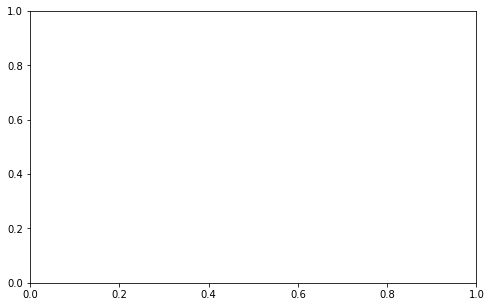

In [42]:
fig, ax = plt.subplots()
fig.set_size_inches(8,5)

ax = sns.distplot(y, kde=False, rug=False, ax=ax, color=tableau20[0]);
ax.set_xlabel("dev utts - avg loss per word in utt", size=20)

In [43]:
for i, (u, l) in enumerate(sorted(utt_loss_normalize.items(), reverse=True, key=lambda t: t[1])[:50]):
    print("-"*80)
    print("{0:d}".format(i))
    print("-"*80)
    generate_translate_probs(u, curr_set='fisher_dev', display_limit=3, display_probs=True)
    loss_v, loss_by_w = check_loss(u, curr_set='fisher_dev')
    #print("{0:20s} ||| {1:5.2f} ||| {2:5.2f} ||| {3:5.2f}".format(u, l, loss_v, loss_by_w))
    print("{0:20s} ||| {3:5.2f}".format(u, l, loss_v, loss_by_w))

NameError: name 'utt_loss_normalize' is not defined

To share:
Several utterrance labels have typos, giving a misleading signal about the prediction quality

"20051017_180712_270_fsp-B-62"
dogs barking

"20051018_210220_279_fsp-A-71"
monopoly money -- monopoly occurs only 5 times in the train set, and never in the context of the game

"20051017_220530_275_fsp-B-61"
the decode probabilities show that maybe beam decoding (? or probably language model) will help catch up to Google. the Google model outputs Texas. We have Texas as the second most probable word as per the acoustic model. 


In [ ]:
x = np.array([[ .759,  0.141,  .053]], dtype=np.float32)
t = np.array([1]).astype('i')
y = F.softmax_cross_entropy(x, t)
y

In [ ]:
batch_data = get_utt_data(eg_utt, curr_set='fisher_dev')

In [ ]:
X, y = batch_data['X'], batch_data['y']

In [ ]:
[vocab_dict['en_w']['i2w'][i] for i in xp.asnumpy(y.data[0])]

### multilabel classification

In [ ]:
bucket_dict['fisher_train']['buckets'][0][:5]

In [ ]:
utt_list = bucket_dict['fisher_train']['buckets'][0][:5]
width_b = bucket_dict['fisher_train']['width_b']
local_input_path = os.path.join(m_cfg['data_path'], m_cfg['train_set'])

In [ ]:
batch_data = get_batch(map_dict["fisher_train"], 
                       enc_key,
                       dec_key,
                       utt_list,
                       vocab_dict,
                       (0+1) * width_b,
                       200,
                       input_path=local_input_path)
    
X, y = batch_data['X'], batch_data['y']

In [ ]:
y.shape, X.shape

In [ ]:
# encode input
model.forward_enc(X)

In [ ]:
y_t = F.swapaxes(y, 0, 1)

In [ ]:
y_t.shape

In [ ]:
len(y_t)

In [ ]:
next_word.data

In [ ]:
t = np.zeros(shape=(len(next_word),10), dtype='i')

In [ ]:
t

In [ ]:
t[0,[1]] = 1

In [ ]:
sim_dict = pickle.load(open("../speech2text/fbanks_80dim_nltk/sim.dict", "rb"))

In [ ]:
sim_dict['i'][4]

In [ ]:
for next_word in y_t:
    print(next_word)
    t = np.zeros(shape=(len(next_word.data), 17000), dtype='i')
    print(next_word.data.tolist())
    for i,w in enumerate(next_word.data.tolist()):
        t[i,sim_dict['i'][w]] = 1
        print(t[i,[4,1044, 1045, 2477]])
    #print(t)

In [ ]:
labels = xp.zeros((5,10)).astype('i')

In [ ]:
next_word = [1,2,3,4,5]

In [ ]:
for i, w in enumerate(next_word):
    print(i, w)
    labels[i,[w]] = 1

In [ ]:
labels

In [ ]:
next_word.data.tolist()

In [ ]:
x = np.random.randn(1,17000).astype('f')
x = np.zeros((1,17000)).astype('f')

In [ ]:
x[0,2] = 10.0
x[0,0] = -10.0

In [ ]:
x

In [ ]:
F.log_softmax(x).data

In [ ]:
t = 0 * np.ones((1,17000), dtype='i')

In [ ]:
t[0,2] = 1

In [ ]:
x, t

In [ ]:
F.sigmoid_cross_entropy(x, t, reduce='no', normalize=False)

In [ ]:
F.sigmoid_cross_entropy(x, t, reduce='no', normalize=True)

In [ ]:
F.sigmoid_cross_entropy(x, t, reduce='mean', normalize=True)

In [ ]:
F.sigmoid_cross_entropy(x, t, reduce='mean', normalize=False)

In [ ]:
F.sigmoid_cross_entropy(x, t, normalize=True)

In [ ]:
x = np.array([[-2.0, 3.0, -2.0], [-2.0, 3.0, -2.0]]).astype('f')
t = np.array([[-1, -1, -1], [0, 1, 0]]).astype('i')

In [ ]:
F.sigmoid_cross_entropy(x, t)

In [ ]:
x = np.zeros((1,10), dtype="f")

In [ ]:
x[0,[2]] = 10.0

In [ ]:
x[:,list(range(2))+list(range(3,10))] = -.2

In [ ]:
x[:,:10]

In [ ]:
t = np.zeros((1,10), dtype="i")
t[0,5] = 1

In [ ]:
F.sigmoid_cross_entropy(x, t)

In [ ]:
predicted_out[:1], xp.argmax(predicted_out[:1].data)

In [ ]:
labels = 0 * xp.ones(predicted_out[:1].shape).astype('i')

In [ ]:
labels.shape

In [ ]:
t = xp.zeros(predicted_out[:1].shape).astype('f')

In [ ]:
t.shape

In [ ]:
t[0,[2,5]] = 50.0

In [ ]:
labels[0,[2,5]] = 1

In [ ]:
F.sigmoid_cross_entropy(t, labels)

In [ ]:
F.sigmoid_cross_entropy(F.softmax(predicted_out[:1]), xp.expand_dims(labels, axis=0))

In [ ]:
from gensim.models import KeyedVectors

In [ ]:
sim_dict['w'][b'rico'], sim_dict['i'][4]

In [ ]:
xp.random.choice(sim_dict['i'][4], 1), sim_dict['i'][w]

In [ ]:
for i in range(len(t_alt)):
    print(t_alt, i)
    print(t_alt[i])
    #t_alt[i] = xp.random.sample(sim_dict['i'][t_alt[i]])

In [ ]:
print(t_alt)
for i in range(len(t_alt)):
    print(xp.random.choice(sim_dict['i'][int(t_alt[i])],1))
    print(t_alt[i],type(t_alt[i]), int(t_alt[i]))

In [ ]:
decoder_batch = y_t
batch_size = decoder_batch.shape[1]
loss = 0
# ---------------------------------------------------------------------
# initialize hidden states as a zero vector
# ---------------------------------------------------------------------
a_units = model.m_cfg['attn_units']
ht = Variable(xp.zeros((batch_size, a_units), dtype=xp.float32))
# ---------------------------------------------------------------------
decoder_input = decoder_batch[0]
# for all sequences in the batch, feed the characters one by one
for curr_word, next_word in zip(decoder_batch, decoder_batch[1:]):
    print(curr_word, next_word)
    decoder_input = curr_word
    # -----------------------------------------------------------------
    # encode tokens
    # -----------------------------------------------------------------
    predicted_out, ht = model.decode(decoder_input, ht)
    decoder_input = F.argmax(predicted_out, axis=1)
    #print(decoder_input)
    # -----------------------------------------------------------------
    # compute loss
    # -----------------------------------------------------------------
    t_alt = xp.copy(next_word.data)
    print(t_alt)
    for i in range(len(t_alt)):
        t_alt[i] = xp.random.choice(sim_dict['i'][int(t_alt[i])],1)
        #print(t[i,[4,1044, 1045, 2477]])
    print(t_alt)

#     t = xp.zeros(shape=predicted_out.shape, dtype='i')
#     print(next_word.data.tolist())
#     print(next_word.shape)
#     for i,w in enumerate(next_word.data.tolist()):
#         if w == PAD_ID:
#             t[i,:] = -1
#         else:
#             t[i,sim_dict['i'][w]] = 1
#         #print(t[i,[4,1044, 1045, 2477]])
#     loss_arr = F.sigmoid_cross_entropy(predicted_out, t, normalize=True)
    loss_arr = F.softmax_cross_entropy(predicted_out, t_alt, normalize=True)
    print("softmax cross entropy:", F.softmax_cross_entropy(predicted_out, next_word), "sigmoid:", loss_arr.data.tolist())
    loss += loss_arr
    
    # -----------------------------------------------------------------
#print(loss, loss / (y.shape[0]-2), y.shape)
print(loss.data.tolist(), (loss / (y.shape[0]-1)).data.tolist())

### Compare BLEU scores at utterance level

In [ ]:
eg_utt = "20051023_232057_325_fsp-A-3"
print(sentence_bleu([google_dev_ref_0[eg_utt]], google_hyp_r0[eg_utt], smoothing_function=smooth_fun.method2))
print(sentence_bleu([model_s2t_refs[eg_utt]], model_s2t_hyps[eg_utt], smoothing_function=smooth_fun.method2))

In [ ]:
eg_utt = "20051019_190221_288_fsp-B-1"
print(sentence_bleu([google_dev_ref_0[eg_utt]], google_hyp_r0[eg_utt], smoothing_function=smooth_fun.method2))
print(sentence_bleu([model_s2t_refs[eg_utt]], model_s2t_hyps[eg_utt], smoothing_function=smooth_fun.method2))
print(google_dev_ref_0[eg_utt], google_hyp_r0[eg_utt])
print(model_s2t_refs[eg_utt], model_s2t_hyps[eg_utt])

In [ ]:
random.seed("haha")
dev_utts = list(model_s2t_refs.keys())
random.shuffle(dev_utts)

In [ ]:
os.makedirs(os.path.join(m_cfg['model_dir'], "probs"))

In [ ]:
print("google beats model by factor of 2")

count = 0
# print("-"*80)
# print("{0:>5s} ||| {1:30s} ||| {2:>15s} || {3:>15s}".format("sn", "utt", "google utt bleu", "model utt bleu"))
# print("-"*80)
for utt in dev_utts:
    if len(model_s2t_refs[utt]) < 10:
        google_utt_bleu = sentence_bleu([google_dev_ref_0[utt]], google_hyp_r0[utt], smoothing_function=smooth_fun.method2)
        model_utt_bleu = sentence_bleu([model_s2t_refs[utt]], model_s2t_hyps[utt], smoothing_function=smooth_fun.method2)
        if google_utt_bleu >= (2 * model_utt_bleu) and google_utt_bleu >= 0.5:
            count += 1
            #print("{0:5d} ||| {1:30s} ||| {2:15.2f} || {3:15.2f}".format(count, utt, google_utt_bleu, model_utt_bleu))
            print("-"*80)
            print(count)
            print("-"*80)
    #         display_pp = PrettyTable(["cat","sent"], hrules=True)
    #         display_pp.align = "l"
    #         display_pp.header = False
    #         display_pp.add_row(["en ref", textwrap.fill(" ".join(model_s2t_refs[utt]),50)])
    #         display_pp.add_row(["model pred", textwrap.fill(" ".join(model_s2t_hyps[utt]),50)])
    #         display_pp.add_row(["model utt bleu", "{0:.2f}".format(model_utt_bleu)])
    #         display_pp.add_row(["google pred", textwrap.fill(" ".join(google_hyp_r0[utt]),50)])
    #         display_pp.add_row(["google utt bleu", "{0:.2f}".format(google_utt_bleu)])
    #         print(display_pp)
    #         play_utt(utt, map_dict['fisher_dev'])
            generate_translate_probs(utt)
        if count > 50:
            break


In [ ]:
vocab_dict['en_w']['i2w'][494]

In [ ]:
eg_utt = "20051009_210519_219_fsp-A-16"
generate_translate_probs(eg_utt)

In [ ]:
print("model beats google by factor of 2")

count = 0
# print("-"*80)
# print("{0:>5s} ||| {1:30s} ||| {2:>15s} || {3:>15s}".format("sn", "utt", "google utt bleu", "model utt bleu"))
# print("-"*80)
for utt in dev_utts:
    if len(model_s2t_refs[utt]) > 3 and len(model_s2t_refs[utt]) < 20:
        google_utt_bleu = sentence_bleu([google_dev_ref_0[utt]], google_hyp_r0[utt], smoothing_function=smooth_fun.method2)
        model_utt_bleu = sentence_bleu([model_s2t_refs[utt]], model_s2t_hyps[utt], smoothing_function=smooth_fun.method2)
        if model_utt_bleu >= (1.5 * google_utt_bleu) and model_utt_bleu >= 0.5:
            count += 1
            #print("{0:5d} ||| {1:30s} ||| {2:15.2f} || {3:15.2f}".format(count, utt, google_utt_bleu, model_utt_bleu))
            print("-"*80)
            print(count)
            print("-"*80)
    #         display_pp = PrettyTable(["cat","sent"], hrules=True)
    #         display_pp.align = "l"
    #         display_pp.header = False
    #         display_pp.add_row(["en ref", textwrap.fill(" ".join(model_s2t_refs[utt]),50)])
    #         display_pp.add_row(["model pred", textwrap.fill(" ".join(model_s2t_hyps[utt]),50)])
    #         display_pp.add_row(["model utt bleu", "{0:.2f}".format(model_utt_bleu)])
    #         display_pp.add_row(["google pred", textwrap.fill(" ".join(google_hyp_r0[utt]),50)])
    #         display_pp.add_row(["google utt bleu", "{0:.2f}".format(google_utt_bleu)])
    #         print(display_pp)
    #         play_utt(utt, map_dict['fisher_dev'])
            generate_translate_probs(utt)
        if count > 50:
            break


In [ ]:
len(vocab_dict['es_w']['w2i']), len(vocab_dict['en_w']['w2i'])

In [ ]:
es_words = set(vocab_dict['es_w']['w2i'].keys())
en_words = set(vocab_dict['en_w']['w2i'].keys())

In [ ]:
len(es_words), len(en_words)

In [ ]:
common_words = es_words & en_words

In [ ]:
len(common_words)

In [ ]:
freq_common_es = {w: vocab_dict['es_w']['freq'][w] for w in common_words}
freq_common_en = {w: vocab_dict['en_w']['freq'][w] for w in common_words}
freq_common_both = {w: (vocab_dict['en_w']['freq'][w], vocab_dict['es_w']['freq'][w]) for w in common_words}


In [ ]:
len(freq_common_es), len(freq_common_en)

In [ ]:
sum(freq_common_es.values()), sum(freq_common_en.values())

In [ ]:
len(vocab_dict['es_w']['freq']), sum(vocab_dict['es_w']['freq'].values()), len(vocab_dict['en_w']['freq']), sum(vocab_dict['en_w']['freq'].values())

In [ ]:
844202 / 1496796, 1282482 / 1497356

In [ ]:
freq_common_en[b'que']

In [ ]:
sorted(freq_common_es.items(), reverse=True, key= lambda t: t[1])

In [ ]:
sorted(freq_common_en.items(), reverse=True, key= lambda t: t[1])

In [ ]:
sorted(freq_common_both.items(), reverse=True, key= lambda t: t[1])

In [ ]:
C = 20
common_in_both = [w for w, (c1, c2) in freq_common_both.items() if c1 >= C and c2 >= C]

In [ ]:
len(common_in_both)

In [ ]:
common_in_both